## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp022'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-3 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

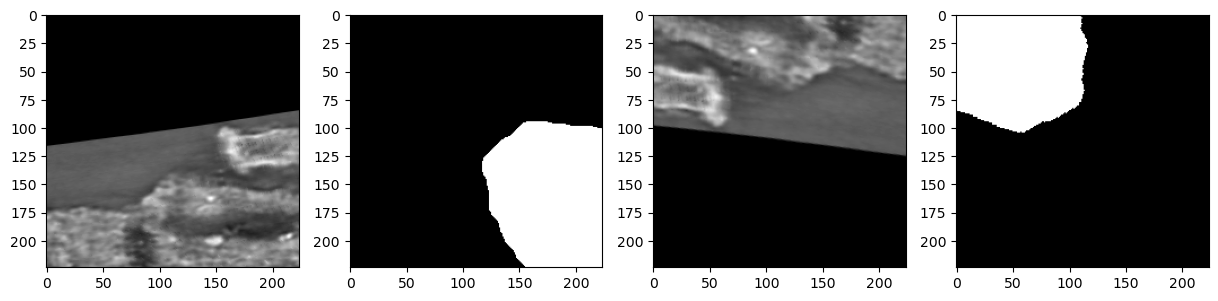

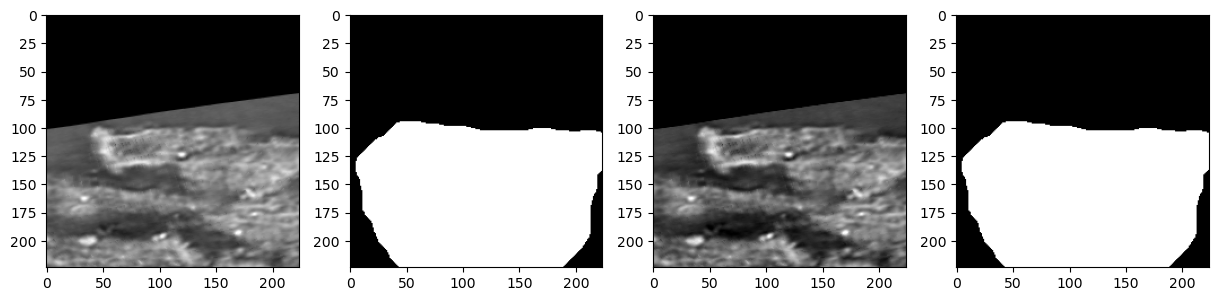

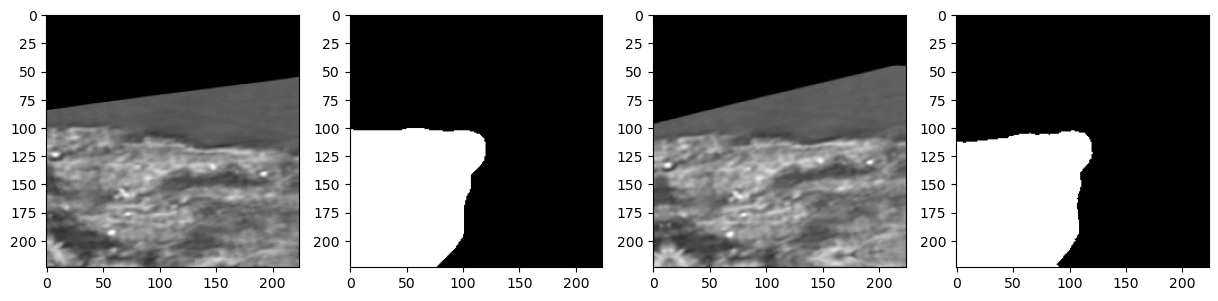

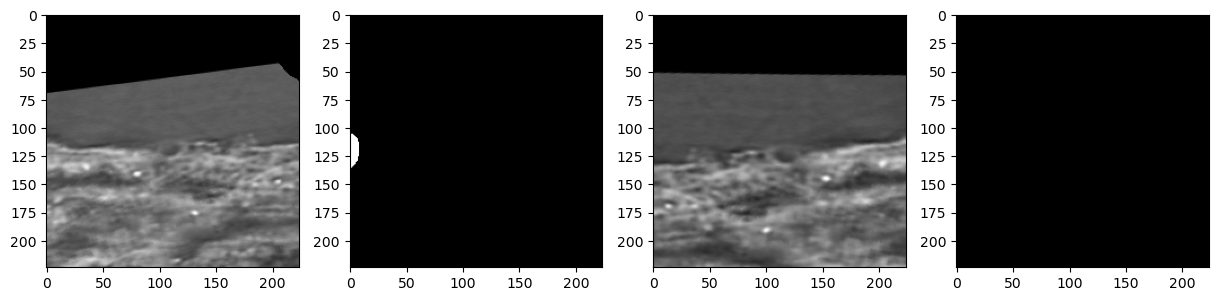

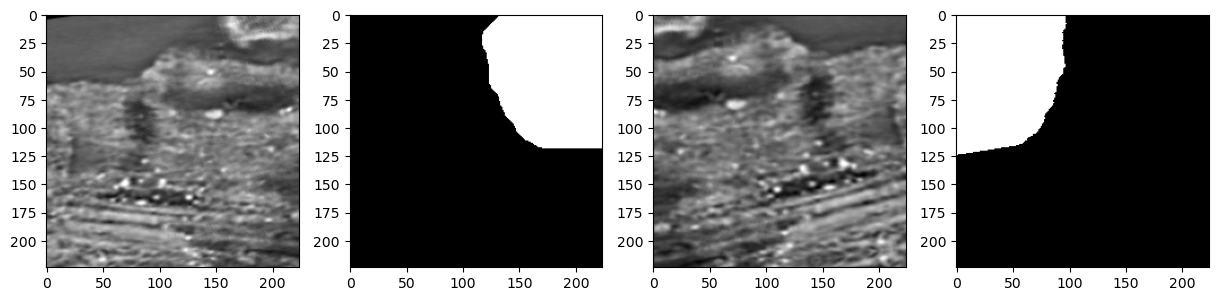

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.24703087804004945
th: 0.15, fbeta: 0.3360831510164781
th: 0.2, fbeta: 0.364084721658931
th: 0.25, fbeta: 0.3395911571417005
th: 0.3, fbeta: 0.30504957800443466
th: 0.35, fbeta: 0.2672383501708099
th: 0.4, fbeta: 0.22790163247060954
th: 0.45, fbeta: 0.19087699505059358


best_th: 0.2, fbeta: 0.364084721658931
Epoch 1 - avg_train_loss: 0.3600  avg_val_loss: 0.3140  time: 114s
Epoch 1 - avgScore: 0.3641
Epoch 1 - Save Best Score: 0.3641 Model
Epoch 1 - Save Best Loss: 0.3140 Model


th: 0.5, fbeta: 0.15420644224996186


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3423196219062236
th: 0.15, fbeta: 0.3711737042802584
th: 0.2, fbeta: 0.3781321577397007
th: 0.25, fbeta: 0.3471095949764067
th: 0.3, fbeta: 0.2929489028040841
th: 0.35, fbeta: 0.2363212399451245
th: 0.4, fbeta: 0.18563819217384145
th: 0.45, fbeta: 0.1426965683072168


best_th: 0.2, fbeta: 0.3781321577397007
Epoch 2 - avg_train_loss: 0.2217  avg_val_loss: 0.3666  time: 117s
Epoch 2 - avgScore: 0.3781
Epoch 2 - Save Best Score: 0.3781 Model
Epoch 2 - Save Best Loss: 0.3666 Model


th: 0.5, fbeta: 0.10524643942479231


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.2931265878376309
th: 0.15, fbeta: 0.33223407814505707
th: 0.2, fbeta: 0.3187848976022585
th: 0.25, fbeta: 0.28381917116669597
th: 0.3, fbeta: 0.24086220461746177
th: 0.35, fbeta: 0.19584044009225024
th: 0.4, fbeta: 0.14701245430941476
th: 0.45, fbeta: 0.09688685426133567


best_th: 0.15, fbeta: 0.33223407814505707
Epoch 3 - avg_train_loss: 0.2436  avg_val_loss: 0.3177  time: 118s
Epoch 3 - avgScore: 0.3322


th: 0.5, fbeta: 0.0


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3393584584135293
th: 0.15, fbeta: 0.2860896064199268
th: 0.2, fbeta: 0.2013128751414952
th: 0.25, fbeta: 0.12842486503965203
th: 0.3, fbeta: 0.06933042007285786
th: 0.35, fbeta: 0.035872662742636556
th: 0.4, fbeta: 0.01815388257645464
th: 0.45, fbeta: 0.007955192762865547


best_th: 0.1, fbeta: 0.3393584584135293
Epoch 4 - avg_train_loss: 0.2239  avg_val_loss: 0.3401  time: 116s
Epoch 4 - avgScore: 0.3394


th: 0.5, fbeta: 0.003046664163225976


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31218122567378187
th: 0.15, fbeta: 0.3252633079934763
th: 0.2, fbeta: 0.20473283733536493
th: 0.25, fbeta: 0.13891930828218524
th: 0.3, fbeta: 0.09777733476702057
th: 0.35, fbeta: 0.0713101841052367
th: 0.4, fbeta: 0.05234089296016453
th: 0.45, fbeta: 0.03747417122062743


best_th: 0.15, fbeta: 0.3252633079934763
Epoch 5 - avg_train_loss: 0.2140  avg_val_loss: 0.3533  time: 114s
Epoch 5 - avgScore: 0.3253


th: 0.5, fbeta: 0.02495914112905942


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.330252184792612
th: 0.15, fbeta: 0.35301290624233395
th: 0.2, fbeta: 0.3600120760652939
th: 0.25, fbeta: 0.3279690200311732
th: 0.3, fbeta: 0.2796246457935526
th: 0.35, fbeta: 0.23046242196242134
th: 0.4, fbeta: 0.18242445915892458
th: 0.45, fbeta: 0.13525464597083353


best_th: 0.2, fbeta: 0.3600120760652939
Epoch 6 - avg_train_loss: 0.2109  avg_val_loss: 0.3807  time: 115s
Epoch 6 - avgScore: 0.3600


th: 0.5, fbeta: 0.09073254463819924


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3192911681986515
th: 0.15, fbeta: 0.35110451171450535
th: 0.2, fbeta: 0.37154932816996034
th: 0.25, fbeta: 0.38509961990122504
th: 0.3, fbeta: 0.3918487010431212
th: 0.35, fbeta: 0.39017569600711927
th: 0.4, fbeta: 0.3815832291520746
th: 0.45, fbeta: 0.36309353410242334


best_th: 0.3, fbeta: 0.3918487010431212
Epoch 7 - avg_train_loss: 0.2084  avg_val_loss: 0.3424  time: 114s
Epoch 7 - avgScore: 0.3918
Epoch 7 - Save Best Score: 0.3918 Model
Epoch 7 - Save Best Loss: 0.3424 Model


th: 0.5, fbeta: 0.3360741683947124


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.361067423266462
th: 0.15, fbeta: 0.37803706781155755
th: 0.2, fbeta: 0.37855628857131035
th: 0.25, fbeta: 0.3693134412308559
th: 0.3, fbeta: 0.3555989497028946
th: 0.35, fbeta: 0.33778781918538947
th: 0.4, fbeta: 0.31679680918479214
th: 0.45, fbeta: 0.29379874736149253


best_th: 0.2, fbeta: 0.37855628857131035
Epoch 8 - avg_train_loss: 0.2037  avg_val_loss: 0.3735  time: 114s
Epoch 8 - avgScore: 0.3786


th: 0.5, fbeta: 0.2685455953040144


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37629394226316687
th: 0.15, fbeta: 0.40440974012432856
th: 0.2, fbeta: 0.39970229067253826
th: 0.25, fbeta: 0.36483153748092007
th: 0.3, fbeta: 0.3113319742183953
th: 0.35, fbeta: 0.2476025187851344
th: 0.4, fbeta: 0.186930012136468
th: 0.45, fbeta: 0.13159210157109108


best_th: 0.15, fbeta: 0.40440974012432856
Epoch 9 - avg_train_loss: 0.2012  avg_val_loss: 0.3821  time: 113s
Epoch 9 - avgScore: 0.4044
Epoch 9 - Save Best Score: 0.4044 Model
Epoch 9 - Save Best Loss: 0.3821 Model


th: 0.5, fbeta: 0.08716185508740341


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38673339157784026
th: 0.15, fbeta: 0.38178631209646396
th: 0.2, fbeta: 0.33822633379112566
th: 0.25, fbeta: 0.2867540377456741
th: 0.3, fbeta: 0.2405829833530672
th: 0.35, fbeta: 0.19839287594839528
th: 0.4, fbeta: 0.16300883860475374
th: 0.45, fbeta: 0.13215531202539116


best_th: 0.1, fbeta: 0.38673339157784026
Epoch 10 - avg_train_loss: 0.1997  avg_val_loss: 0.3879  time: 114s
Epoch 10 - avgScore: 0.3867


th: 0.5, fbeta: 0.10545394979657374


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32175707115316016
th: 0.15, fbeta: 0.34426332459233483
th: 0.2, fbeta: 0.3584124122319004
th: 0.25, fbeta: 0.36526829575158065
th: 0.3, fbeta: 0.36558830208216797
th: 0.35, fbeta: 0.3613696250707864
th: 0.4, fbeta: 0.35461389813741273
th: 0.45, fbeta: 0.34066866368513155


best_th: 0.3, fbeta: 0.36558830208216797
Epoch 11 - avg_train_loss: 0.1954  avg_val_loss: 0.3764  time: 113s
Epoch 11 - avgScore: 0.3656


th: 0.5, fbeta: 0.3235242577524948


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3554358274182474
th: 0.15, fbeta: 0.3851713824022206
th: 0.2, fbeta: 0.4011895526236844
th: 0.25, fbeta: 0.40440865692271716
th: 0.3, fbeta: 0.40013896459401654
th: 0.35, fbeta: 0.3862651375548248
th: 0.4, fbeta: 0.36223558179313986
th: 0.45, fbeta: 0.3309418610147958


best_th: 0.25, fbeta: 0.40440865692271716
Epoch 12 - avg_train_loss: 0.1910  avg_val_loss: 0.3873  time: 114s
Epoch 12 - avgScore: 0.4044


th: 0.5, fbeta: 0.2908646891784546


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3692112993031709
th: 0.15, fbeta: 0.39063818665680083
th: 0.2, fbeta: 0.3988417677671119
th: 0.25, fbeta: 0.39687468092740347
th: 0.3, fbeta: 0.3834507755544965
th: 0.35, fbeta: 0.3618330341965412
th: 0.4, fbeta: 0.33449845626014485
th: 0.45, fbeta: 0.30241438854765623


best_th: 0.2, fbeta: 0.3988417677671119
Epoch 13 - avg_train_loss: 0.1883  avg_val_loss: 0.3867  time: 114s
Epoch 13 - avgScore: 0.3988


th: 0.5, fbeta: 0.26660622002022666


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3855641038591345
th: 0.15, fbeta: 0.3710727558388664
th: 0.2, fbeta: 0.33664786595025525
th: 0.25, fbeta: 0.2967512988849262
th: 0.3, fbeta: 0.2526890179146327
th: 0.35, fbeta: 0.2089852582416083
th: 0.4, fbeta: 0.16841163324221792
th: 0.45, fbeta: 0.13258107403113792


best_th: 0.1, fbeta: 0.3855641038591345
Epoch 14 - avg_train_loss: 0.1868  avg_val_loss: 0.4254  time: 113s
Epoch 14 - avgScore: 0.3856


th: 0.5, fbeta: 0.10164525575719147


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4117419540538557
th: 0.15, fbeta: 0.40718987304098025
th: 0.2, fbeta: 0.38961785380080843
th: 0.25, fbeta: 0.3631982917514692
th: 0.3, fbeta: 0.33303840487248765
th: 0.35, fbeta: 0.29929153984724444
th: 0.4, fbeta: 0.2632447494168578
th: 0.45, fbeta: 0.22659874571893562


best_th: 0.1, fbeta: 0.4117419540538557
Epoch 15 - avg_train_loss: 0.1860  avg_val_loss: 0.4770  time: 113s
Epoch 15 - avgScore: 0.4117
Epoch 15 - Save Best Score: 0.4117 Model
Epoch 15 - Save Best Loss: 0.4770 Model


th: 0.5, fbeta: 0.19362217887888514


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.302474614651787
th: 0.15, fbeta: 0.25031278958057124
th: 0.2, fbeta: 0.1990465127520088
th: 0.25, fbeta: 0.15904168992288806
th: 0.3, fbeta: 0.12620905781211633
th: 0.35, fbeta: 0.10145953129415602
th: 0.4, fbeta: 0.07811022287555694
th: 0.45, fbeta: 0.05818343997140414


best_th: 0.1, fbeta: 0.302474614651787
Epoch 16 - avg_train_loss: 0.1806  avg_val_loss: 0.5996  time: 114s
Epoch 16 - avgScore: 0.3025


th: 0.5, fbeta: 0.041997798546880925


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3785128545524446
th: 0.15, fbeta: 0.3703797456706012
th: 0.2, fbeta: 0.3485084316452093
th: 0.25, fbeta: 0.3166884810747062
th: 0.3, fbeta: 0.2815486322865534
th: 0.35, fbeta: 0.24137867782260256
th: 0.4, fbeta: 0.20336058168251006
th: 0.45, fbeta: 0.16880721611130903


best_th: 0.1, fbeta: 0.3785128545524446
Epoch 17 - avg_train_loss: 0.1765  avg_val_loss: 0.4315  time: 115s
Epoch 17 - avgScore: 0.3785


th: 0.5, fbeta: 0.1382494707355448


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4055923273278232
th: 0.15, fbeta: 0.4091538840606269
th: 0.2, fbeta: 0.39087878636351864
th: 0.25, fbeta: 0.3610833410656562
th: 0.3, fbeta: 0.3270672379875832
th: 0.35, fbeta: 0.2910874078390412
th: 0.4, fbeta: 0.25328961375525755
th: 0.45, fbeta: 0.21817077600696658


best_th: 0.15, fbeta: 0.4091538840606269
Epoch 18 - avg_train_loss: 0.1737  avg_val_loss: 0.4070  time: 114s
Epoch 18 - avgScore: 0.4092


th: 0.5, fbeta: 0.1881143520875713


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3934175450297526
th: 0.15, fbeta: 0.3942821448532093
th: 0.2, fbeta: 0.36478060502170756
th: 0.25, fbeta: 0.319585724170344
th: 0.3, fbeta: 0.27196334787751736
th: 0.35, fbeta: 0.22530096628130739
th: 0.4, fbeta: 0.18446740410649215
th: 0.45, fbeta: 0.1470379481324951


best_th: 0.15, fbeta: 0.3942821448532093
Epoch 19 - avg_train_loss: 0.1668  avg_val_loss: 0.4124  time: 113s
Epoch 19 - avgScore: 0.3943


th: 0.5, fbeta: 0.11407277973317578


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38845019180397217
th: 0.15, fbeta: 0.40842880080916466
th: 0.2, fbeta: 0.41343910704618475
th: 0.25, fbeta: 0.4019928091683724
th: 0.3, fbeta: 0.38360160886646355
th: 0.35, fbeta: 0.35836358217658554
th: 0.4, fbeta: 0.32449013532377496
th: 0.45, fbeta: 0.2887146946719359


best_th: 0.2, fbeta: 0.41343910704618475
Epoch 20 - avg_train_loss: 0.1672  avg_val_loss: 0.4002  time: 115s
Epoch 20 - avgScore: 0.4134
Epoch 20 - Save Best Score: 0.4134 Model
Epoch 20 - Save Best Loss: 0.4002 Model


th: 0.5, fbeta: 0.25192021769538586


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3636866278336021
th: 0.15, fbeta: 0.3120122241882292
th: 0.2, fbeta: 0.2608940882140507
th: 0.25, fbeta: 0.2119036427605811
th: 0.3, fbeta: 0.17395874133739173
th: 0.35, fbeta: 0.14396578268320323
th: 0.4, fbeta: 0.116646422341738
th: 0.45, fbeta: 0.09037057299447908


best_th: 0.1, fbeta: 0.3636866278336021
Epoch 21 - avg_train_loss: 0.1639  avg_val_loss: 0.5363  time: 115s
Epoch 21 - avgScore: 0.3637


th: 0.5, fbeta: 0.06842432432458047


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40127817908647045
th: 0.15, fbeta: 0.41447031474947893
th: 0.2, fbeta: 0.41013299019757604
th: 0.25, fbeta: 0.3969997375218303
th: 0.3, fbeta: 0.37654355724439864
th: 0.35, fbeta: 0.34772997253871957
th: 0.4, fbeta: 0.3134927682406904
th: 0.45, fbeta: 0.2807695349984033


best_th: 0.15, fbeta: 0.41447031474947893
Epoch 22 - avg_train_loss: 0.1594  avg_val_loss: 0.4604  time: 113s
Epoch 22 - avgScore: 0.4145
Epoch 22 - Save Best Score: 0.4145 Model
Epoch 22 - Save Best Loss: 0.4604 Model


th: 0.5, fbeta: 0.24955794510897192


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4247520329980652
th: 0.15, fbeta: 0.416407560184559
th: 0.2, fbeta: 0.3934325008964906
th: 0.25, fbeta: 0.36538310966793
th: 0.3, fbeta: 0.33322719941636586
th: 0.35, fbeta: 0.30050516799130184
th: 0.4, fbeta: 0.268020154688598
th: 0.45, fbeta: 0.2365562232853197


best_th: 0.1, fbeta: 0.4247520329980652
Epoch 23 - avg_train_loss: 0.1554  avg_val_loss: 0.4903  time: 115s
Epoch 23 - avgScore: 0.4248
Epoch 23 - Save Best Score: 0.4248 Model
Epoch 23 - Save Best Loss: 0.4903 Model


th: 0.5, fbeta: 0.20455916122055762


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39812451076115996
th: 0.15, fbeta: 0.3994343374027293
th: 0.2, fbeta: 0.3798252221931823
th: 0.25, fbeta: 0.3569792336947892
th: 0.3, fbeta: 0.3281697237527804
th: 0.35, fbeta: 0.2955017108890455
th: 0.4, fbeta: 0.2637158675642576
th: 0.45, fbeta: 0.23482732363426373


best_th: 0.15, fbeta: 0.3994343374027293
Epoch 24 - avg_train_loss: 0.1520  avg_val_loss: 0.5042  time: 114s
Epoch 24 - avgScore: 0.3994


th: 0.5, fbeta: 0.20737147248587182


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39251061139459303
th: 0.15, fbeta: 0.412432663085329
th: 0.2, fbeta: 0.4088738177825252
th: 0.25, fbeta: 0.39001876734920143
th: 0.3, fbeta: 0.3627720934564145
th: 0.35, fbeta: 0.3362052000657745
th: 0.4, fbeta: 0.30628469243950973
th: 0.45, fbeta: 0.27310399367252164


best_th: 0.15, fbeta: 0.412432663085329
Epoch 25 - avg_train_loss: 0.1507  avg_val_loss: 0.4606  time: 113s
Epoch 25 - avgScore: 0.4124


th: 0.5, fbeta: 0.2403261143488774


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39723853392658365
th: 0.15, fbeta: 0.39704742493083445
th: 0.2, fbeta: 0.381319544336806
th: 0.25, fbeta: 0.3585715599125114
th: 0.3, fbeta: 0.33055629787585417
th: 0.35, fbeta: 0.2979005294009963
th: 0.4, fbeta: 0.2670301896472428
th: 0.45, fbeta: 0.24141993336781142


best_th: 0.1, fbeta: 0.39723853392658365
Epoch 26 - avg_train_loss: 0.1475  avg_val_loss: 0.5303  time: 114s
Epoch 26 - avgScore: 0.3972


th: 0.5, fbeta: 0.21569410954228507


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3900747761148153
th: 0.15, fbeta: 0.3639018174809956
th: 0.2, fbeta: 0.3281323047993737
th: 0.25, fbeta: 0.2904131145312555
th: 0.3, fbeta: 0.2587524427635264
th: 0.35, fbeta: 0.23013028067581723
th: 0.4, fbeta: 0.2022945016212454
th: 0.45, fbeta: 0.1754751241804693


best_th: 0.1, fbeta: 0.3900747761148153
Epoch 27 - avg_train_loss: 0.1461  avg_val_loss: 0.5796  time: 114s
Epoch 27 - avgScore: 0.3901


th: 0.5, fbeta: 0.15010940182019858


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.390403832049928
th: 0.15, fbeta: 0.3814368395291333
th: 0.2, fbeta: 0.3600169548586577
th: 0.25, fbeta: 0.3333585688860928
th: 0.3, fbeta: 0.3053092588621982
th: 0.35, fbeta: 0.27839264984406975
th: 0.4, fbeta: 0.25305811839557746
th: 0.45, fbeta: 0.2291116831052104


best_th: 0.1, fbeta: 0.390403832049928
Epoch 28 - avg_train_loss: 0.1405  avg_val_loss: 0.5573  time: 113s
Epoch 28 - avgScore: 0.3904


th: 0.5, fbeta: 0.20444466908057884


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39595472700639256
th: 0.15, fbeta: 0.3932760649063482
th: 0.2, fbeta: 0.3799621573881701
th: 0.25, fbeta: 0.3571990489169849
th: 0.3, fbeta: 0.33114778162475916
th: 0.35, fbeta: 0.30312682685534625
th: 0.4, fbeta: 0.27313780967653534
th: 0.45, fbeta: 0.24567414550327493


best_th: 0.1, fbeta: 0.39595472700639256
Epoch 29 - avg_train_loss: 0.1379  avg_val_loss: 0.5192  time: 114s
Epoch 29 - avgScore: 0.3960


th: 0.5, fbeta: 0.22064321944211085


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3885445665391036
th: 0.15, fbeta: 0.3616400335438301
th: 0.2, fbeta: 0.3287447271472091
th: 0.25, fbeta: 0.29529045366634543
th: 0.3, fbeta: 0.26238815557531614
th: 0.35, fbeta: 0.23355503513358522
th: 0.4, fbeta: 0.20663899873080643
th: 0.45, fbeta: 0.18120403610470717


best_th: 0.1, fbeta: 0.3885445665391036
Epoch 30 - avg_train_loss: 0.1401  avg_val_loss: 0.5455  time: 113s
Epoch 30 - avgScore: 0.3885


th: 0.5, fbeta: 0.1589123906190972


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.4247520329980652
th: 0.15, fbeta: 0.416407560184559
th: 0.2, fbeta: 0.3934325008964906
th: 0.25, fbeta: 0.36538310966793
th: 0.3, fbeta: 0.33322719941636586
th: 0.35, fbeta: 0.30050516799130184
th: 0.4, fbeta: 0.268020154688598
th: 0.45, fbeta: 0.2365562232853197


best_th: 0.1, fbeta: 0.4247520329980652


th: 0.5, fbeta: 0.20455916122055762


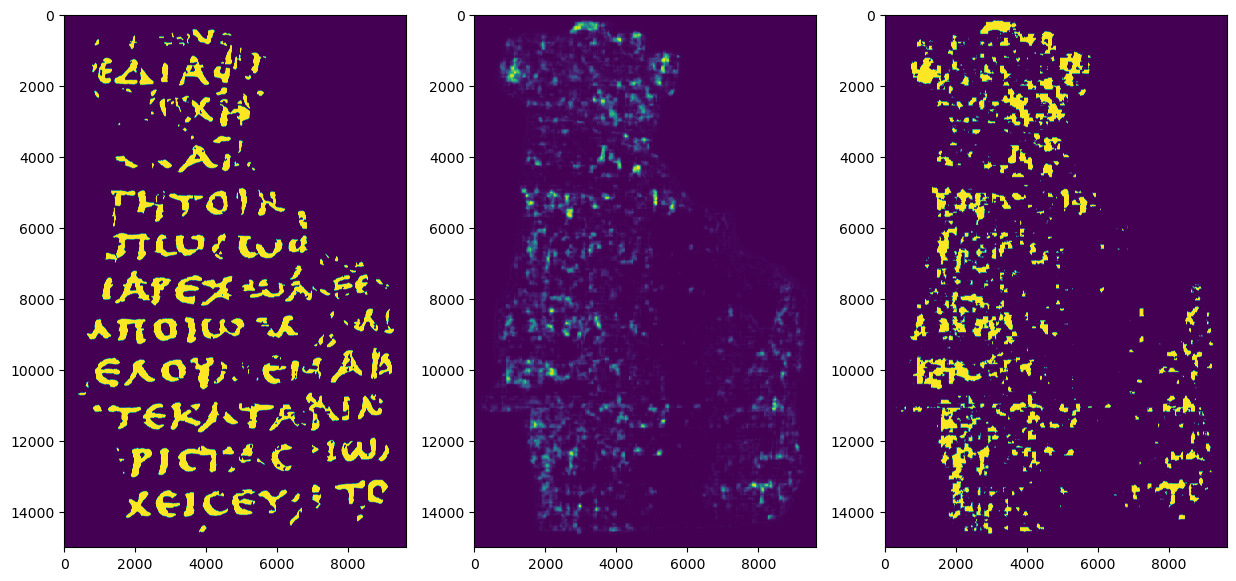

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.24506705e+08, 8.22726400e+06, 3.90545900e+06, 2.18754400e+06,
        1.38951800e+06, 9.79331000e+05, 7.27379000e+05, 5.42908000e+05,
        4.17084000e+05, 3.42009000e+05, 2.74233000e+05, 2.16810000e+05,
        1.89405000e+05, 1.58360000e+05, 1.28266000e+05, 1.11838000e+05,
        9.53820000e+04, 7.96420000e+04, 5.94530000e+04, 1.84660000e+04]),
 array([8.91451551e-10, 4.96515066e-02, 9.93030124e-02, 1.48954518e-01,
        1.98606024e-01, 2.48257530e-01, 2.97909035e-01, 3.47560541e-01,
        3.97212047e-01, 4.46863553e-01, 4.96515058e-01, 5.46166564e-01,
        5.95818070e-01, 6.45469576e-01, 6.95121081e-01, 7.44772587e-01,
        7.94424093e-01, 8.44075599e-01, 8.93727104e-01, 9.43378610e-01,
        9.93030116e-01]),
 <BarContainer object of 20 artists>)

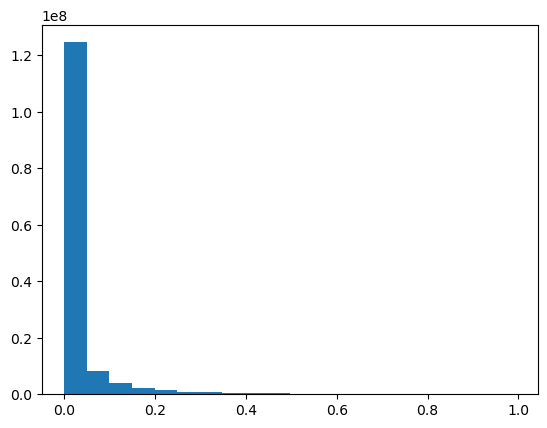

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000